<a href="https://colab.research.google.com/github/KarthikeyaniShanmugam/hello/blob/master/Copy_of_lesson_1_export_jit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fast.ai lesson 1 - training on Notebook Instance and export to torch.jit model

## Overview
This notebook shows how to use the SageMaker Python SDK to train your fast.ai model on a SageMaker notebook instance then export it as a torch.jit model to be used for inference on AWS Lambda.

## Set up the environment

You will need a Jupyter notebook with the `boto3` and `fastai` libraries installed. You can do this with the command `pip install boto3 fastai`

This notebook was created and tested on a single ml.p3.2xlarge notebook instance. 


## Train your model

We are going to train a fast.ai model as per [Lesson 1 of the fast.ai MOOC course](https://course.fast.ai/videos/?lesson=1) locally on the SageMaker Notebook instance. We will then save the model weights and upload them to S3.



In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [57]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'


Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
import io
import tarfile

import PIL

import boto3

from fastai.vision import *

In [58]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [59]:

path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [21]:
# path_anno.ls()
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_92.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_189.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_101.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_202.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_198.jpg')]

In [0]:
bs=64 
img_size=299

In [24]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=224, bs=bs//2)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
yorkshire_terrier,Birman,samoyed,Egyptian_Mau,basset_hound
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
english_cocker_spaniel,British_Shorthair,boxer,Birman,keeshond
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

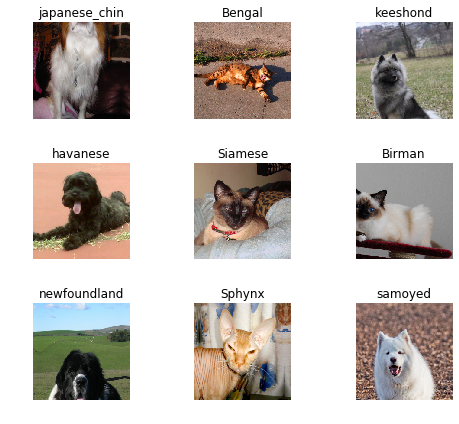

In [25]:
data.show_batch(rows=3,figsize=(7,6))

In [26]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [29]:
# len(data.classes)
data.c

37

In [45]:
  learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 21.4MB/s]


In [46]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.794374,0.437197,0.123816,02:16
1,0.521312,0.246265,0.075101,02:08
2,0.362525,0.206183,0.064953,02:15
3,0.217397,0.183346,0.058863,02:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


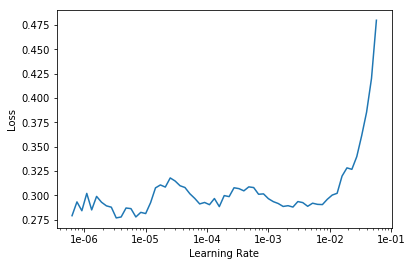

In [33]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

In [34]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.260715,0.209674,0.061570,01:58
1,0.233895,0.194501,0.064953,01:59
2,0.219722,0.191706,0.061570,01:57


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

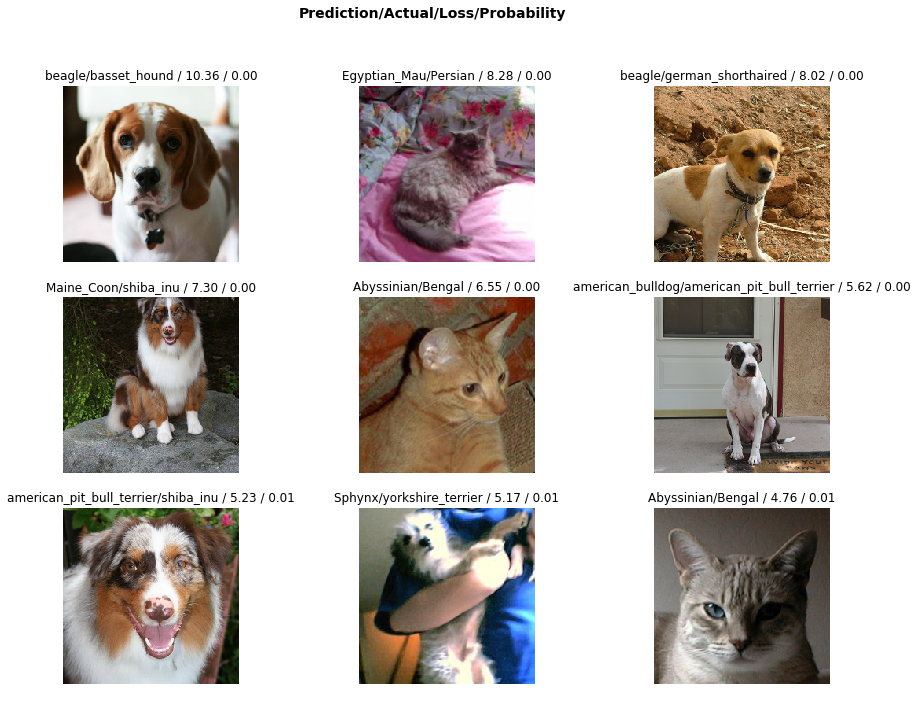

In [37]:
interp.plot_top_losses(9,figsize=(15,11))

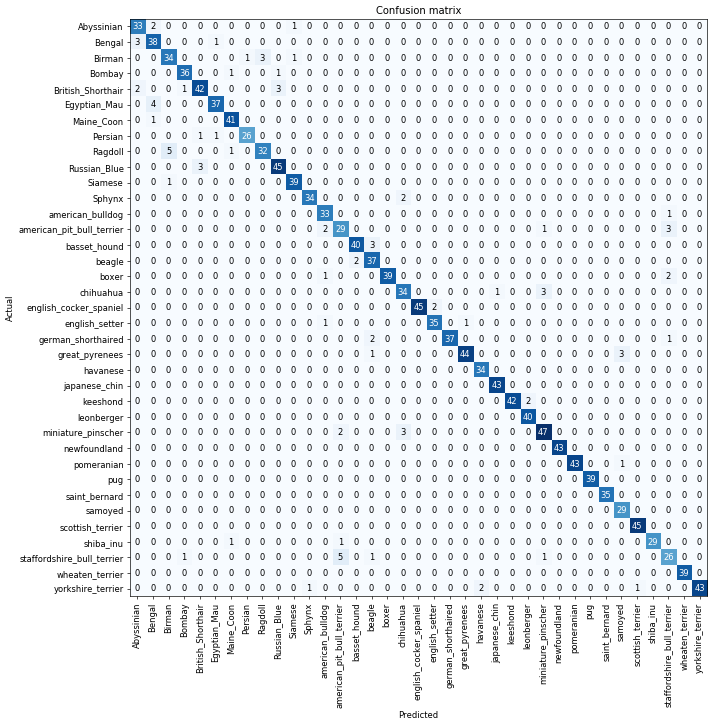

In [38]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [39]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Birman', 'Ragdoll', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('basset_hound', 'beagle', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('great_pyrenees', 'samoyed', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Abyssinian', 'Bengal', 2),
 ('British_Shorthair', 'Abyssinian', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'staffordshire_bull_terrier', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('german_shorthaired', 'beagle', 2),
 ('keeshond', 'leonberger', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('yorkshire_terrier', 'havanese', 2)]

In [0]:
learn.unfreeze()

In [43]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.396289,0.283210,0.083897,02:07


## Export model and upload to S3

Now that we have trained our model we need to export it, create a tarball of the artefacts and upload to S3.


First we need to export the class names from the data object into a text file.

In [0]:
save_texts(path_img/'models/classes.txt', data.classes)

Now we need to export the model in the [PyTorch TorchScript format](https://pytorch.org/docs/stable/jit.html) so we can load into an AWS Lambda function.

In [0]:
trace_input = torch.ones(1,3,img_size,img_size).cuda()
jit_model = torch.jit.trace(learn.model.float(), trace_input)
model_file='resnet50_jit.pth'
output_path = str(path_img/f'models/{model_file}')
torch.jit.save(jit_model, output_path)

Next step is to create a tarfile of the exported classes file and model weights.

In [0]:

tar_file=path_img/'models/model.tar.gz'
classes_file='classes.txt'

In [0]:
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path_img/f'models/{model_file}', arcname=model_file)
    f.add(path_img/f'models/{classes_file}', arcname=classes_file)

Now we need to upload the model tarball to S3.

In [51]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file(str(tar_file), '', 'fastai-models/lesson1/model.tar.gz')

NoCredentialsError: ignored